In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

## Part 1 Compare Euclidean distance and Dynamic Time Warping distance

Let's first generate some time series data. Generate the x and y for the following functions and plot the three lines.


ts1: $y=3\sin(\frac{x}{1.5})+3.5$


ts2: $y=2.2\sin(\frac{x}{3.5}x+2.4)+3.2$


ts3: $y=0.04x+3$

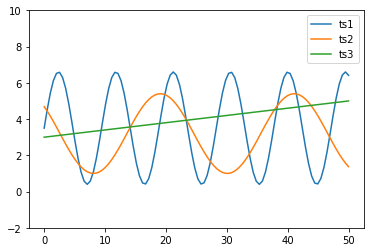

In [2]:
x = np.linspace(0, 50, 100)
ts1 = 3.1 * np.sin(x / 1.5) + 3.5
ts2 = 2.2 * np.sin(x / 3.5 + 2.4) + 3.2
ts3 = 0.04 * x + 3.0

plt.plot(x, ts1, label='ts1')
plt.plot(x, ts2, label='ts2')
plt.plot(x, ts3, label='ts3')
plt.ylim(-2, 10)
plt.legend()

In a typycal time series problem, one important thing is to determine the similarity between two series. There are several methods to compute the similarity. Here, you are provided with Euclidean distance and Dynamic Time Warping(DTW) distance. You need to fill the follwoing cells to construct these two distances and compare them. 

### Euclidean distance 
Euclidean distance between two time series A and B is define as
$$
d(A, B)=\sqrt{\sum_{i=1}^{n}[A(i)-B(i)]^{2}}
$$
where A and B are n dim

In [3]:
def euclid_dist(a, b):
    return np.linalg.norm(a - b)

### Q1.1: Report the Euclidean distance of ts1 and ts2 as well as ts1 and ts3. Based on Euclidean distance, which series is more similar to ts1?

In [4]:
Eu_12 = euclid_dist(ts1, ts2)
Eu_13 = euclid_dist(ts1, ts3)

Eu_12, Eu_13

(26.95921603796934, 23.18924919031106)

### Answer: ts3 is more similar to ts1 since the euclid_dist is smaller. However, this is opposite to our intuition since the two sine function should be more similar. 

### Dynamic Time Warping
Sometimes two series are very similar but their axises maybe distorted(e.g. time-axis). DTW distance finds the optimum alignment between two sequences of observations by warping the time dimension. Here is a detailed resource for the concept: https://en.wikipedia.org/wiki/Dynamic_time_warping

In [5]:
def dtw_dist(a, b):
    dtw = {}

    for i in range(len(a)):
        dtw[(i, -1)] = float('inf')
    for i in range(len(b)):
        dtw[(-1, i)] = float('inf')
    dtw[(-1, -1)] = 0

    for i in range(len(a)):
        for j in range(len(b)):
            dist_2 = (a[i] - b[j]) ** 2
            dtw[(i, j)] = dist_2 + np.min((dtw[(i-1, j)], dtw[(i, j-1)], dtw[(i-1, j-1)]))

    return np.sqrt(dtw[(len(a) - 1, len(b) - 1)])


### Q1.2: Report the DTW distance of ts1 and ts2 as well as ts1 and ts3. Based on Euclidean distance, which series is more similar to ts1?

In [6]:
Dtw_12 = dtw_dist(ts1, ts2)
Dtw_13 = dtw_dist(ts1, ts3)

Dtw_12, Dtw_13

(17.929718468641134, 21.549494824404572)

### Answer: ts2 is more similar to ts1 since the dtw_dist is smaller. This is the same as our intuition. 

### Faster DTW algorithm
DTW consumes too much time since it needs to traverse all the data points which give a complexity of $O(nm)$. Actually we don't need to compute the two points that are too far away. This threshold can be set by a parameter $r$. Fill the cell below and report the distance.

In [7]:
def dtw_dist_fast(a, b, r=5):
    dtw = {}

    r = np.max((r, np.abs(len(a) - len(b))))

    for i in range(-1, len(a)):
        for j in range(-1, len(b)):
            dtw[(i, j)] = float('inf')
    dtw[(-1, -1)] = 0

    for i in range(len(a)):
        for j in range(np.max((0, i-r)), np.min((len(b), i+r))):
            dist_2 = (a[i] - b[j]) ** 2
            dtw[(i, j)] = dist_2 + np.min((dtw[(i-1, j)], dtw[(i, j-1)], dtw[(i-1, j-1)]))

    return np.sqrt(dtw[(len(a) - 1, len(b) - 1)])

In [8]:
Dtw_f_12 = dtw_dist_fast(ts1, ts2, 10)
Dtw_f_13 = dtw_dist_fast(ts1, ts3, 10)

Dtw_f_12, Dtw_f_13

(18.59655183841726, 22.47248284679103)

### LB Keogh
LB Keogh is an even faster method than fast DTW distance. We don't expect you to understand the concept here, so we provide you with the codes. Report the distance with this method.

In [9]:
def LB_Keogh(a, b, r):
    LB_sum=0
    for idx,i in enumerate(a):
        
        lower_bound=min(b[(idx-r if idx-r>=0 else 0):(idx+r)])
        upper_bound=max(b[(idx-r if idx-r>=0 else 0):(idx+r)])
        
        if i > upper_bound:
            LB_sum = LB_sum + (i - upper_bound) ** 2
        elif i < lower_bound:
            LB_sum = LB_sum + (i - lower_bound) ** 2
    
    return np.sqrt(LB_sum)


In [10]:
LB_12 = LB_Keogh(ts1, ts2, 10)
LB_13 = LB_Keogh(ts1, ts3, 10)

LB_12, LB_13

(10.96456042004128, 21.54116703422889)

## Part 2 Apply KNN+DTW method and classification on UCI dataset

UCI dataset(https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) collects the infomation of embedded accelerometer and gyroscope in people's mobile phone when people perform six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING). Let's first load the data. 

In [11]:
def load_data(path='UCI_HAR_Dataset/train/X_train.txt'):
    with open(path, 'r') as file:
        data = file.readlines()

    x_train = []
    for line in data:
        x_train.append([float(x) for x in line.split()])

    return np.array(x_train)

In [12]:
labels = {1:'WALKING',
          2:'WALKING UPSTAIRS', 
          3:'WALKING DOWNSTAIRS',
          4:'SITTING', 
          5:'STANDING', 
          6:'LAYING'}

Here x_train and x_test contains all the infomation from the mobile. y_train and y_test are the labels of people's activities. 

In [13]:
x_train = load_data('UCI_HAR_Dataset/train/X_train.txt')
y_train = load_data('UCI_HAR_Dataset/train/y_train.txt')
x_test = load_data('UCI_HAR_Dataset/test/X_test.txt')
y_test = load_data('UCI_HAR_Dataset/test/y_test.txt')

### KNN
Fill the following cell and construct a KNN model. Here we set k=1

Use DTW to determine whether two data points are similar. Think about how to make use of LB Keogh to accelerate the training process. (Hint: run LB Keogh first to narrow the traversing range)

In [70]:
def knn(train_x, train_y, test_x, test_y, r):
    preds=[]
    for idx_i, Xtest in enumerate(test_x):
        min_dist=float('inf')

        for idx_j, Xtrain in enumerate(train_x):
            if LB_Keogh(Xtest, Xtrain, 5) < min_dist:
                dist = dtw_dist_fast(Xtest, Xtrain, r)
                if dist < min_dist:
                    min_dist = dist
                    closest_label = train_y[idx_j]
        preds.append(closest_label)

    return preds

### Q2.1 Predict the testing set and report your accuracy 
(Attention: The running time is very large if you use all the training data. We suggest to reduce the size of training set)

In [57]:
y_pred = knn(x_train[:30,:], y_train[:30], x_test[:10,:], y_test[:10], 4)

In [56]:
print(classification_report(y_test[:5], y_pred))

              precision    recall  f1-score   support

         5.0       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

